<a href="https://colab.research.google.com/github/yohan2001colombo/DataScience/blob/main/Brownian_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import scipy.stats as stats
from math import sqrt
from scipy.stats import norm

In [2]:
#!pip install kaggle
from google.colab import files
data = files.upload()

Saving Talawakelle Tea Estate Stock Price History.csv to Talawakelle Tea Estate Stock Price History.csv


In [3]:
import pandas as pd
df = pd.read_csv("Talawakelle Tea Estate Stock Price History.csv")
print(df.head())

        Date  Closing Price
0  10/3/2022           98.8
1  10/4/2022           94.5
2  10/5/2022           98.7
3  10/6/2022           98.5
4  10/7/2022          100.0


In [4]:
len(df)

480

In [5]:
# a)
df["time_index"] = range(len(df))  # Starts at 0, increments by 1

In [6]:
df.head()

,Date,Closing Price,time_index
0,10/3/2022,98.8,0
1,10/4/2022,94.5,1
2,10/5/2022,98.7,2
3,10/6/2022,98.5,3
4,10/7/2022,100.0,4


In [7]:
log_returns = np.log(df["Closing Price"]/df["Closing Price"].shift(1)).dropna()

In [8]:
sigma_2 = np.var(log_returns)
mu = np.mean(log_returns) + sigma_2/2

In [9]:
# b)
print(f"Scale parameter: {np.sqrt(sigma_2):.4f}")
print(f"Drift parameter mu: {mu:.4f}")

Scale parameter: 0.0251
Drift parameter mu: 0.0008


In [10]:
# c)
# (A) Normality test
shapiro_stat, p_value = shapiro(log_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")  # p < 0.05 → not normal


Shapiro-Wilk p-value: 0.0000


Shapiro-Wilk p-value of 0.0000 for TPL's log returns provides strong statistical evidence against normality

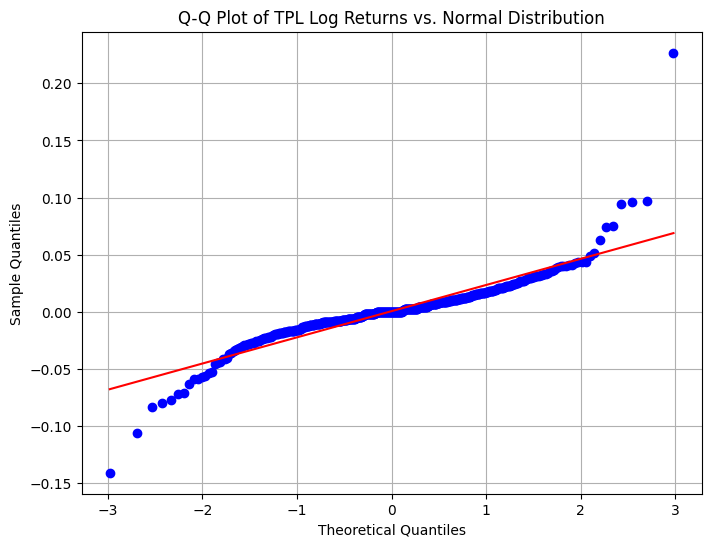

In [11]:
# Generate Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
plt.title("Q-Q Plot of TPL Log Returns vs. Normal Distribution")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid()
plt.show()

GBM is inappropriate for TPL’s closing prices because:

* GBM assumes log returns are normally distributed, but TPL’s returns violate this.


<Figure size 1000x400 with 0 Axes>

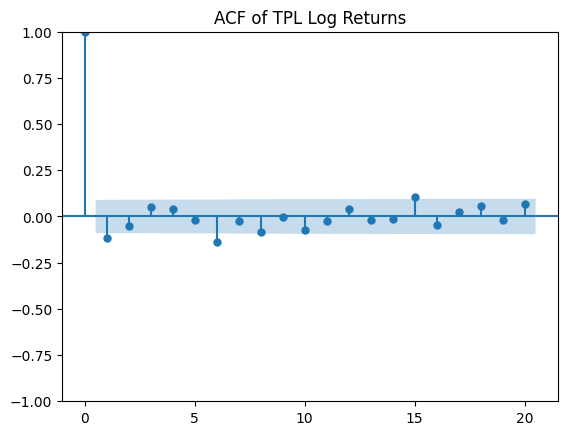

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 4))
plot_acf(log_returns, lags=20, alpha=0.05, title="ACF of TPL Log Returns")
plt.show()

GBM Assumption Violation:

* GBM requires no autocorrelation (independent increments).

* TPL shows significant autocorrelation at multiple lags → GBM is inappropriate.

Market Behavior Suggested by ACF:

* Positive autocorrelation (Lags 1-5):

  * Short-term momentum (past returns influence future returns).

  * Example: If TPL rose yesterday, it’s likely to rise today.

* Negative autocorrelation (Lags 10-20):

  * Long-term mean reversion (overbought/oversold reversals).

There are two assumptions must
be satisfied for GBM process. There are normality of
the log ratios and the independence from the previous
data.

In [13]:
df.tail()

,Date,Closing Price,time_index
475,9/25/2024,124.75,475
476,9/26/2024,122.00,476
477,9/27/2024,126.50,477
478,9/30/2024,126.25,478
479,10/1/2024,126.25,479


In [29]:
def BrownianG(m, T, N, sigma, mu, w0, GB = False):
  """
    m = Number of sample paths
    T = Total time
    sigma = scale parameter
    N = number of steps
    mu = drift parameter
    wo = initial value

    Return
    ----------
    numpy array of shape (m, N+1), where the first column
    gives the initial values of each path
  """
  # time step
  dt = T/N
  # creating an array to store simulated values
  x = np.zeros((m, N+1))
  # initial values
  x[:, 0] = w0
  x0 = x[:, 0]

  if not GB:
    r = norm.rvs(size=x0.shape + (N,), loc = mu*dt, scale = sigma*sqrt(dt))
    np.cumsum(r, axis=-1, out=x[:, 1:])
    x[:,1:]  += w0

  else:
     r = norm.rvs(size=x0.shape + (N,), loc = mu*dt, scale = sigma*sqrt(dt))
     np.cumsum(r, axis=-1, out=x[:, 1:])

     if w0 != 0:
      x[:,1:] = w0*np.exp(x[:,1:])
     else :
      x[:,1:] = np.exp(x[:,1:])

  return x



In [30]:
m = 10000
T = 20
sigma = np.sqrt(sigma_2)
N = 150
mu = mu
w0 = df["Closing Price"][len(df)-1]
t0 = 0
t1 = df["time_index"][len(df)-1]

y = BrownianG(m,T,N,sigma,mu,w0,True) # Geometric Brownian Motion


In [31]:
y

array([[126.25      , 126.95806239, 128.16729944, ..., 137.38709163,
        136.32686269, 139.5444889 ],
       [126.25      , 126.67753285, 125.42561133, ..., 119.57832265,
        120.4498306 , 120.34373446],
       [126.25      , 127.62046877, 127.85922287, ..., 130.37634014,
        130.44559443, 127.93783714],
       ...,
       [126.25      , 124.43219915, 123.88279866, ...,  99.34831653,
         99.82472727,  98.43817396],
       [126.25      , 123.83657454, 124.91330714, ..., 131.6544172 ,
        131.2488064 , 129.4512519 ],
       [126.25      , 126.84959448, 128.97174787, ..., 152.71399599,
        151.34692367, 151.25368658]])

In [32]:
def BrownianPlot(y,T):
  """
    Arguments
    -----------
    y-array with shape (m,N+1). Each row gives discritizeed version
    of a sample path.There are m sample paths
    T-Total Time

    Returns
    ----------
    A plot of the sample paths
  """

  # Number of steps
  N = y.shape[1]
  # Length of time step
  dt = T/(N-1)

  t = np.linspace(t1, t1+N*dt, N)
  for k in range(y.shape[0]):
    plt.plot(t,y[k])

  # Set x-axis to show only integer values
  plt.xticks(np.arange(t1, t1+T+1, step=max(1, int(T/10))),  # Ensure at least step=1
               fontsize=12)

  plt.xlabel('Time', fontsize=15)
  plt.ylabel('W_t', fontsize=15)
  plt.title(f'Geometric Brownian Motion from t={t1} to t={t1+T}', fontsize=15)
  #plt.grid(True)
  plt.show()

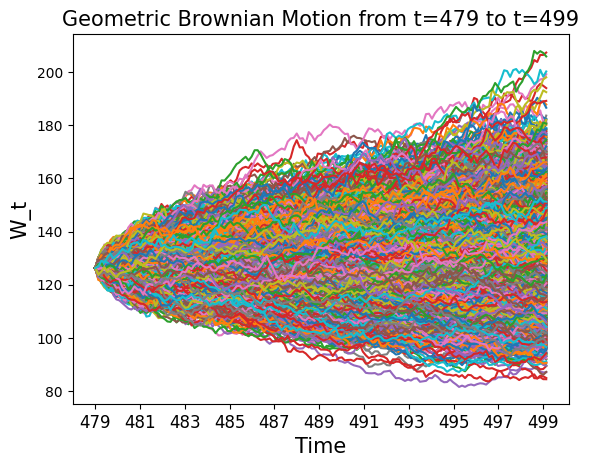

In [33]:
BrownianPlot(y,T)

In [40]:
def BrownianPlot(y,T):
  """
    Arguments
    -----------
    y-array with shape (m,N+1). Each row gives discritizeed version
    of a sample path.There are m sample paths
    T-Total Time

    Returns
    ----------
    A plot of the sample paths
  """
  ht = np.linspace(t0, t1, len(df))

  plt.plot(ht, df["Closing Price"], 'b-', linewidth=2, label='Historical Data')
  # Number of steps
  N = y.shape[1]
  # Length of time step
  dt = T/(N-1)

  t = np.linspace(t1, t1+N*dt, N)
  for k in range(y.shape[0]):
    plt.plot(t,y[k])
  plt.xlabel('Time', fontsize=15)
  plt.ylabel('W_t', fontsize=15)
  plt.show()

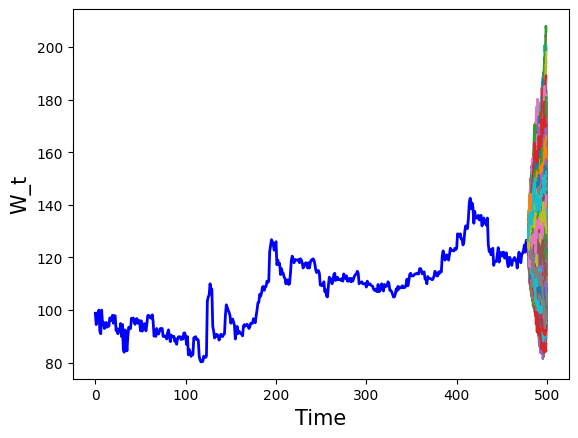

In [41]:
BrownianPlot(y,T)

In [45]:
y.shape

(10000, 151)

In [42]:
def BrownianEnd(y,T,loc):
  """
  Arguments
  ----------
  y-array with shape (m,N+1).Each row gives discritized version
  of a sample path. There are a sample paths
  T-total time
  loc-location of graph

  Returns
  ---------
  A histogram of values which are obtained by discritizing the sample
  paths at the given location
  """

  # Number of steps
  N = y.shape[1]
  # Length of a step
  dt = T/(N-1)
  # The position of the array corresponding to the given location
  pos = int(loc/dt)
  # Histogram
  plt.hist(y[:,pos],bins=25,density=True)
  plt.show()

In [46]:
dfGBM = pd.DataFrame(y.T)
dfGBM

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,...,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000,126.250000
1,126.958062,126.677533,127.620469,126.020590,127.121621,124.723371,124.991601,124.951672,124.866590,127.039640,...,125.592316,125.734263,127.819556,125.829439,126.951773,125.427589,125.845623,124.432199,123.836575,126.849594
2,128.167299,125.425611,127.859223,126.334650,129.268319,123.916734,124.026163,124.232667,125.467270,130.059532,...,125.861546,123.846340,128.143655,125.624998,125.862112,124.987024,126.296685,123.882799,124.913307,128.971748
3,126.554437,126.213235,127.195818,124.900729,127.786042,126.031548,123.080685,122.622815,128.489724,131.809354,...,126.255706,124.006862,125.933227,123.114534,126.580485,124.618103,125.576780,124.751185,126.528223,128.389098
4,126.942039,123.971051,123.990710,123.657487,128.215183,127.536923,121.269534,120.683317,127.228047,131.142184,...,127.463938,123.752211,126.689234,121.772635,124.105935,124.145097,125.152635,123.550429,124.743415,130.260043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,139.384523,119.756441,130.426951,122.052444,88.656330,125.173343,103.162251,117.106921,144.201062,131.482712,...,146.699118,129.208556,128.680286,142.899614,109.579230,114.151374,141.865724,97.382434,132.659073,151.279626
147,138.630270,120.785332,129.830019,123.141574,88.579485,124.477163,103.636736,116.010577,144.289785,129.447929,...,144.044097,131.162984,128.793753,143.002130,107.935585,113.370285,141.766916,98.968932,131.379771,151.021214
148,137.387092,119.578323,130.376340,125.312146,87.300350,125.297762,102.905085,117.402701,144.324214,130.013710,...,143.768394,129.450824,129.648753,143.714030,107.855063,114.615304,143.454707,99.348317,131.654417,152.713996
149,136.326863,120.449831,130.445594,125.203132,86.962322,123.616044,102.075952,117.062991,145.315212,128.179820,...,143.321025,128.227599,129.772015,145.081477,107.113286,114.127675,143.091011,99.824727,131.248806,151.346924


In [47]:
endingValueGBM = dfGBM.loc[150] # last row
endingValueGBM.describe()

,150
count,10000.000000
mean,129.379252
std,14.567197
min,84.400570
25%,119.160529
50%,128.504013
75%,138.619894
max,207.379169


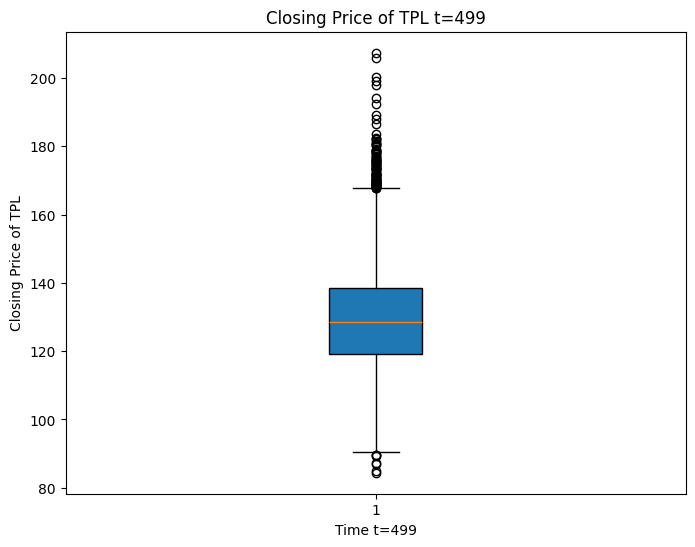

In [48]:
# Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(endingValueGBM, patch_artist=True)
plt.title('Closing Price of TPL t=499')
plt.xlabel('Time t=499')
plt.ylabel('Closing Price of TPL')

plt.show()

In [51]:
len(endingValueGBM[(endingValueGBM > 130) & (endingValueGBM < 140)])/len(endingValueGBM)

0.2368

In [52]:
# 95% prediction interval for endingValues
np.percentile(endingValueGBM,[2.5,97.5])

array([103.33234346, 160.16761258])